# wrfout绘图

* 有了前面的积累现在可以正式对wrfout进行后处理绘图了。
* 以下将以庐山地区预报场为例，分别绘制：伪彩色图、填色等值线图、矢量图、剖面图。
* 实际进行后处理绘图时，请按需选择伪彩色图或填色等值线图。

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cartopy.io.shapereader import Reader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from netCDF4 import Dataset
from wrf import (
    CoordPair,
    get_cartopy,
    getvar,
    interplevel,
    interpline,
    latlon_coords,
    vertcross,
)

filepath = Path(
    "/public/home/premopr/data/archive/GERGLS/GFS_WCTRL/2024032800",
)
filename = Path("wrfout_d03_2024-03-28_00:00:00.GFS_WCTRL_P+FCST.p")

## 数据处理

数据处理部分将得到后续所需的**所有**变量。
* 伪彩色图+矢量图：地面累计降水、$700 \ \mathrm{hPa}$风场。
* 填色等值线图：地面累计降水、$700 \ \mathrm{hPa}$雷达反射率。
* 伪彩色图+矢量图+剖面图：$700 \ \mathrm{hPa}$云水混合比、$700 \ \mathrm{hPa}$风场、指定剖面的云水混合比与地面高度。

In [2]:
# ==读取wrfout文件==
ncfile = Dataset(filepath / filename)

# ==读取变量==
# 以下二维变量的坐标是南北+东西
# 三维变量的坐标则是底顶+南北+东西
# 地面累计降水（二维变量，单位：mm）
rain = getvar(ncfile, "RAINNC")
# 质量网格点上的风速（三维变量，单位：m s-1）
u = getvar(ncfile, "ua")
v = getvar(ncfile, "va")
# 气压（三维变量，单位：hPa）
pres = getvar(ncfile, "pressure")
# 雷达反射率（三维变量，单位：dBZ）
dbz = getvar(ncfile, "dbz")
# 云水混合比（三维变量，单位：kg kg-1）
# 乘1000后单位为g kg-1
qc = getvar(ncfile, "QCLOUD") * 1000
# 地面高度（二维变量，单位：m）
ter = getvar(ncfile, "ter")
# 格点海拔高度（三维变量，单位：m）
z = getvar(ncfile, "z")

# ==读取元数据==
# 经纬度
lat, lon = latlon_coords(rain)
# 投影
proj = get_cartopy(rain)

# ==设置剖面起止点的经纬度==
start = CoordPair(lat=28.5, lon=116)
end = CoordPair(lat=29, lon=117)

# ==插值到指定剖面==
# 将云水混合比以海拔高度为垂直坐标插值到指定剖面
# levels表示垂直坐标的分层方式
# 这里是最低0m、最高20000m，一共分101层，即每层间距200m
# 正常情况下可以忽略掉该参数
# 但没有levels出来的垂直坐标全是nan（原因不明）
qc_cross = vertcross(
    qc,
    z,
    levels=np.linspace(0, 20000, 101),
    wrfin=ncfile,
    start_point=start,
    end_point=end,
    latlon=True,
    meta=True,
)
# 将地面高度插值到指定剖面
ter_cross = interpline(ter, wrfin=ncfile, start_point=start, end_point=end)

# ==插值到700hPa等压面==
u = interplevel(u, pres, 700)
v = interplevel(v, pres, 700)
dbz = interplevel(dbz, pres, 700)
qc = interplevel(qc, pres, 700)

## 添加省界线

* 美观起见有时会在绘制wrfout时添加对应的省界线。
* 以下是固定的读取省界线数据并添加到子图上的代码。
* 在可能需要自定义修改的地方添加了注释，其余部分一般不用改动。
* 这次的绘图区域没有包括海岸线，如果有需要请添加`ax.coastlines()`。

In [3]:
def ax2ax(ax: GeoAxes, *, bottom: bool = True, left: bool = True) -> None:
    """为子图添加省界线.

    Args:
        ax (GeoAxes): 输入子图.
        bottom (bool, optional): 是否显示子图底部的刻度标签. Defaults to True.
        left (bool, optional): 是否显示子图左侧的刻度标签. Defaults to True.

    """
    if bottom:
        bottom = "x"
    if left:
        left = "y"
    china_map = cfeature.ShapelyFeature(
        Reader(
            "/public/home/XiaAnRen/share/data/ChinaShp202407/China_p.shp",
        ).geometries(),
        ccrs.PlateCarree(),
        linewidth=1,
        edgecolor="black",
        facecolor="none",
        alpha=1,
    )
    ax.add_feature(china_map, linewidth=0.5, zorder=2)
    ax.gridlines(
        draw_labels={"bottom": bottom, "left": left},
        dms=False,
        x_inline=False,
        y_inline=False,
        rotate_labels=False,
        linestyle=":",
        linewidth=0.3,
        color="black",
        xlabel_style={"size": 16},
        ylabel_style={"size": 16},
        xformatter=LongitudeFormatter(),
        yformatter=LatitudeFormatter(),
        xlocs=[114.5, 115, 115.5, 116, 116.5, 117],  # x轴刻度
    )
    ax.spines["geo"].set_linewidth(0.6)
    ax.tick_params(labelsize=16)

## 伪彩色图+矢量图

可用的colormap包括：
* Matplotlib内置的colormap：<https://matplotlib.org/stable/users/explain/colors/colormaps.html>  
  使用时直接`cmap="jet"`
* NCL内置的colormap：<https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml>  
  可以导入`cmaps`以使用

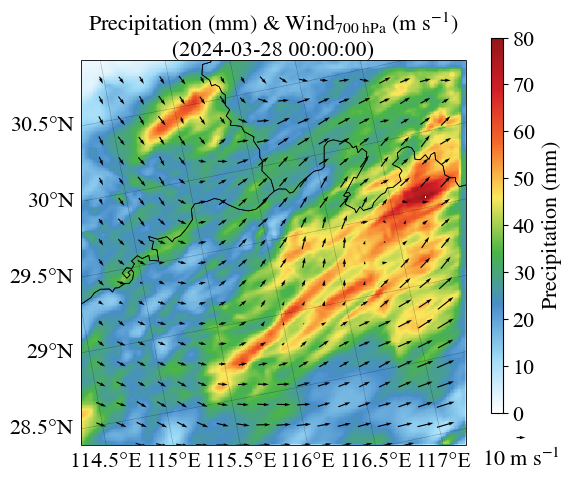

In [4]:
# ==创建画布与子图==
fig = plt.figure(figsize=(6, 5))
# 创建子图时额外规定了投影方式
ax = fig.subplots(1, 1, subplot_kw={"projection": proj})

# ==添加省界线==
ax2ax(ax)

# ==绘制伪彩色图==
# 绘制地面累计降水的伪彩色图
pcm = ax.pcolormesh(
    lon,  # x轴是经度
    lat,  # y轴是纬度
    rain,  # 按照该变量的值进行上色
    cmap=cmaps.WhiteBlueGreenYellowRed,  # 选用colormap
    norm=mcolors.Normalize(vmin=0, vmax=80),  # 规定colorbar的最大最小值
    transform=ccrs.PlateCarree(),  # 必须要有的投影到平面坐标系的坐标变换
)
# 添加colorbar
# orientation可以设定为vertical（垂直）或horizontal（水平）
# 默认是垂直
# cax部分的四个参数分别代表：
# 相对左边界的距离、相对下边界的距离、colorbar的宽度、colorbar的高度
cbar = fig.colorbar(
    pcm,  # 绑定对应关系
    orientation="vertical",  # 垂直放置
    cax=fig.add_axes([0.875, 0.175, 0.02, 0.75]),  # 位置和大小
    ticks=np.linspace(0, 80, 9),  # 刻度
)
# 设置标签文本
cbar.set_label(
    "$\\mathrm{ Precipitation \\ \\left( mm \\right) }$",
    fontsize=16,
)
# 设置刻度字号
cbar.ax.tick_params(labelsize=16)

# ==绘制矢量图==
# 绘制700hPa等压面上的风矢量图
# 后面三个参数非必要不用管
quiver = ax.quiver(
    lon,  # x轴是经度
    lat,  # y轴是纬度
    u,  # 矢量场U分量
    v,  # 矢量场V分量
    pivot="mid",  # 箭头旋转的基准点
    regrid_shape=20,  # 矢量图的重采样形状
    transform=ccrs.PlateCarree(),  # 坐标变换
)
# 添加参考矢量
# labelpos的值包括“E”、“W”、“S”、“N”
# 即东西南北
# coordinates表示前面的位置坐标是相对整个figure还是当前axes
ax.quiverkey(
    quiver,  # 绑定对应关系
    0.925,  # 参考矢量位置的x坐标
    0.125,  # 参考矢量位置的y坐标
    10,  # 参考矢量对应的数值
    "$\\mathrm{ 10 \\ m \\ s^{-1} }$",  # 标签文本
    labelpos="S",  # 标签位置
    coordinates="figure",  # 坐标系统
    fontproperties={"size": 16},  # 字号
)

# ==添加图题==
# 参数含义与之前的ax.text()基本一致
ax.set_title(
    (
        "$\\mathrm{ Precipitation \\ \\left( mm \\right) }$"
        " & "
        "$\\mathrm{ Wind_{700 \\ hPa} \\ \\left( m \\ s^{-1} \\right) }$"
        f"\n({pd.to_datetime(rain.Time.data).strftime(r'%Y-%m-%d %H:%M:%S')})"
    ),
    ha="center",
    fontsize=16,
    transform=ax.transAxes,
)

# ==展示图像==
fig.show()

## 填色等值线图

* 这里其实可以看到使用`subfigure`的另一个好处。  
  即在每个`subfigure`都需要添加`colorbar`的时候，可以在不同`subfigure`内使用相同位置。  
  省去了重复调整位置的麻烦。

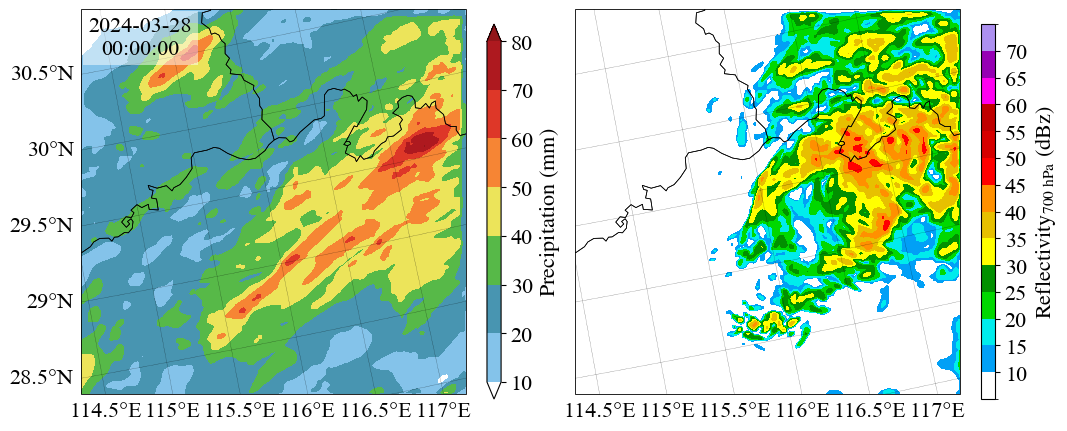

In [5]:
# ==创建画布、子画布、子图==
fig = plt.figure(figsize=(12, 5))
subfigs = fig.subfigures(1, 2, wspace=-0.3)

# ==在第一张子画布上绘制图像==
subfig = subfigs[0]
# 创建1行1列的子图并设置投影
ax = subfig.subplots(1, 1, subplot_kw={"projection": proj})
# 添加省界线
ax2ax(ax)
# 绘制地面累计降水的填色等值线图
# 这里contourf中的f代表filled即填充颜色
# 对应有contour即不填充颜色的等值线图
# 参数与pcolormesh基本一致
# 多出来的extend="both"代表colorbar的两端显示为尖头
cf = ax.contourf(
    lon,
    lat,
    rain,
    cmap=cmaps.WhiteBlueGreenYellowRed,
    norm=mcolors.Normalize(vmin=0, vmax=80),
    extend="both",
    transform=ccrs.PlateCarree(),
)
# 添加colorbar
# 与前面相比唯一的区别在于添加到了subfig
# 位置中的各项参数也是相对于subfig进行设置的
cbar = subfig.colorbar(
    cf,
    orientation="vertical",
    cax=subfig.add_axes([0.815, 0.1, 0.02, 0.75]),
    ticks=np.linspace(10, 80, 8),
)
cbar.set_label(
    "$\\mathrm{ Precipitation \\ \\left( mm \\right) }$",
    fontsize=16,
)
cbar.ax.tick_params(labelsize=16)
# 添加文本
# 文本内容是根据提取出的变量元数据中的时刻
# 将其转换成datetime类型，再格式化为字符串所得到的
ax.text(
    0.155,
    0.925,
    pd.to_datetime(rain.Time.data).strftime("%Y-%m-%d\n%H:%M:%S"),
    ha="center",
    va="center",
    fontsize=16,
    transform=ax.transAxes,
    bbox={"facecolor": "white", "alpha": 0.5, "lw": 0},
)

# ==在第二张子画布上绘制图像==
subfig = subfigs[1]
# 设置子画布的背景颜色为None
# 防止默认的白色盖住其他子画布或其他元素
# 比如参考矢量或colorbar
subfig.set_facecolor("none")
# 创建1行1列的子图并设置投影
ax = subfig.subplots(1, 1, subplot_kw={"projection": proj})
# 添加省界线时设置子图左侧不显示刻度标签
ax2ax(ax, left=False)
# 这里自定义的colormap来自：
# http://nmc.cn/publish/area/china/radar.html
cmap = mcolors.ListedColormap(
    [
        "#FFFFFF",
        "#01A0F6",
        "#00ECEC",
        "#00D800",
        "#019000",
        "#FFFF00",
        "#E7C000",
        "#FF9000",
        "#FF0000",
        "#D60000",
        "#C00000",
        "#FF00F0",
        "#9600B4",
        "#AD90F0",
    ],
)
# 规定刻度
# levels也可以是不等距的、只包含数字的列表
levels = np.linspace(5, 75, 15)
# 将自定义的colormap与levels传入所绘制的填色等值线图内
cf = ax.contourf(
    lon,
    lat,
    dbz,
    cmap=cmap,
    levels=levels,
    norm=mcolors.BoundaryNorm(levels, len(levels) - 1),
    transform=ccrs.PlateCarree(),
)
# 添加colorbar
cbar = subfig.colorbar(
    cf,
    orientation="vertical",
    cax=subfig.add_axes([0.815, 0.1, 0.02, 0.75]),
    ticks=levels[1:-1],
)
cbar.set_label(
    "$\\mathrm{ Reflectivity_{700 \\ hPa} \\ \\left( dBz \\right) }$",
    fontsize=16,
)
cbar.ax.tick_params(labelsize=16)

# ==展示图像==
fig.show()

## 伪彩色图+矢量图+剖面图

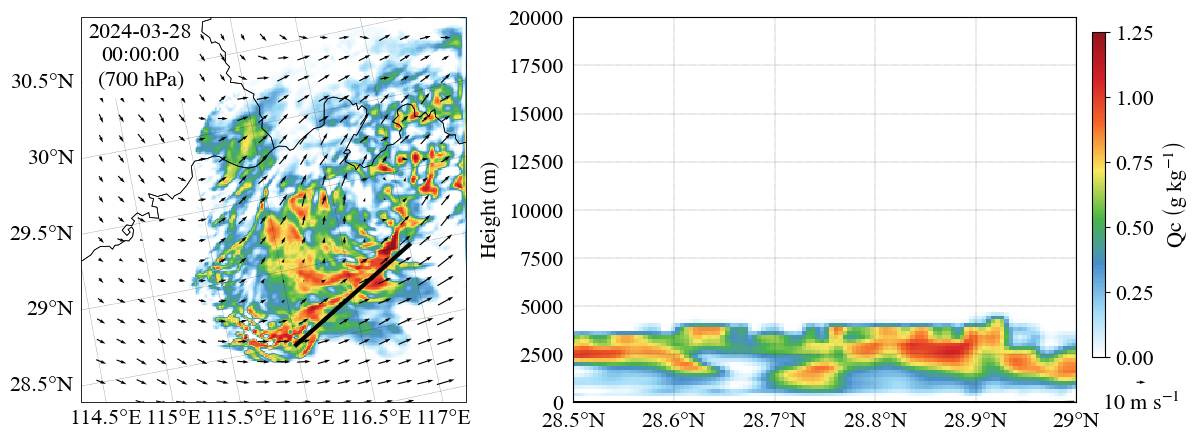

In [6]:
# ==创建画布、子画布、子图==
fig = plt.figure(figsize=(12, 5))
subfigs = fig.subfigures(1, 2, wspace=-0.15)

# ==在第一张子画布上绘制图像==
subfig = subfigs[0]
ax = subfig.subplots(1, 1, subplot_kw={"projection": proj})
ax2ax(ax)
# 绘制700hPa等压面上云水混合比的伪彩色图
pcm = ax.pcolormesh(
    lon,
    lat,
    qc,
    cmap=cmaps.WhiteBlueGreenYellowRed,
    norm=mcolors.Normalize(vmin=0, vmax=1.25),
    transform=ccrs.PlateCarree(),
)
# 绘制剖面
# 即画一条连接起止点的直线
ax.plot(
    [start.lon, end.lon],
    [start.lat, end.lat],
    color="black",
    linewidth=3,
    transform=ccrs.PlateCarree(),
)
# 绘制700hPa等压面上的风矢量图
quiver = ax.quiver(
    lon,
    lat,
    u,
    v,
    pivot="mid",
    regrid_shape=20,
    transform=ccrs.PlateCarree(),
)
# 添加参考矢量
# 考虑到多了一张子图因此位置有所调整
ax.quiverkey(
    quiver,
    1,
    0.15,
    10,
    "$\\mathrm{ 10 \\ m \\ s^{-1} }$",
    labelpos="S",
    coordinates="figure",
    fontproperties={"size": 16},
)
# 添加文本
# 文本下方还有其他矢量
# 因此为了防止互相混在一起将不透明度设为了1
# 即完全不透明
ax.text(
    0.155,
    0.895,
    (
        pd.to_datetime(qc.Time.data).strftime("%Y-%m-%d\n%H:%M:%S")
        + "\n$\\mathrm{{ \\left( 700 \\ hPa \\right) }}$"
    ),
    ha="center",
    va="center",
    fontsize=16,
    transform=ax.transAxes,
    bbox={"facecolor": "white", "alpha": 1, "lw": 0},
)

# ==在第二张子画布上绘制图像==
subfig = subfigs[1]
subfig.set_facecolor("none")
ax = subfig.subplots(1, 1)
# 提取纬度坐标
x = [coord.lat for coord in qc_cross.coords["xy_loc"].data]
# 提取海拔高度坐标
y = qc_cross.coords["vertical"].data
# 绘制云水混合比的剖面图
# 其中x轴是纬度、y轴是海拔高度
ax.pcolormesh(
    x,
    y,
    qc_cross,
    cmap=cmaps.WhiteBlueGreenYellowRed,
    norm=mcolors.Normalize(vmin=0, vmax=1.25),
)
# 绘制地面高度的剖面图
# x轴是纬度
# y轴方向上：在0与地面高度之间进行填充
# 同时设置所填充的边缘颜色为黑色、内部颜色为白色、填充样式为"///"
ax.fill_between(
    x,
    0,
    ter_cross,
    edgecolor="black",
    facecolor="white",
    hatch="///",
)
# 添加网格线
ax.grid(linestyle=":", linewidth=0.3, color="k")
# 设置x轴、y轴的范围
ax.set_xlim(start.lat, end.lat)
ax.set_ylim(0, 20000)
# 设置y轴的标签
ax.set_ylabel("$\\mathrm{ Height \\ \\left( m \\right) }$", fontsize=16)
# 设置x轴刻度样式为“纬度”
ax.xaxis.set_major_formatter(LatitudeFormatter())
# 设置刻度字号
# 不显示底部与左侧的刻度线
ax.tick_params(labelsize=16, bottom=False, left=False)
# 添加colorbar
cbar = subfig.colorbar(
    pcm,
    orientation="vertical",
    cax=subfig.add_axes([0.925, 0.2, 0.02, 0.65]),
    ticks=np.linspace(0, 1.25, 6),
)
cbar.set_label(
    "$\\mathrm{ Qc \\ \\left( g \\ kg^{{-1}} \\right) }$",
    fontsize=16,
)
cbar.ax.tick_params(labelsize=16)

# ==展示图像==
fig.show()

图像的地面高度不太明显，因此额外展示了之前所画过的其他地面高度剖面图的效果。

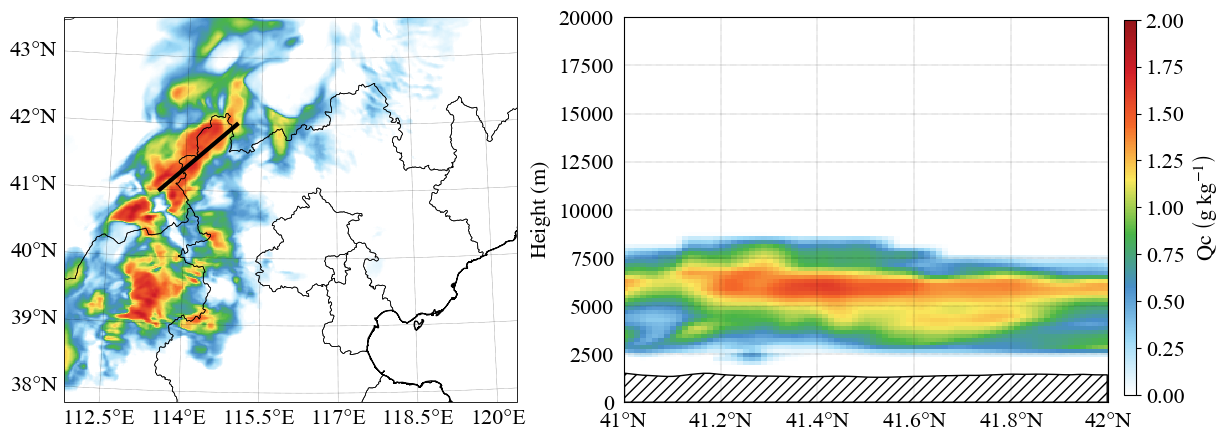

In [ ]:
# 这是正常绘图所不需要的模块
# 因此将其拎出来单独导入
# （复读上一文档内容）
from IPython.display import Image

Image("/public/home/XiaAnRen/share/tutorial2024/plt6.png")